# Investment Game
The rules of the investment game are outlined in the `README.md`. Here we are implementing a simple environment in order to play the game.

In [1]:
import numpy as np
import gym

## Time-series for assets

In [2]:
import seaborn as sns
import pandas as pd
sns.set()

/home/malte/anaconda3/envs/rl-invest/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/malte/anaconda3/envs/rl-invest/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/malte/anaconda3/envs/rl-invest/lib/python3.8/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/malte/anaconda3/envs/rl-invest/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
# creating artificial time-series data


In [70]:
from scipy import interpolate

In [176]:
std_dev_noise = 3
x_max = 100
y_min, y_max = [10, 50]
num_nodes = 10
x_range = np.arange(1, x_max-1)
values = np.arange(y_min, y_max)

In [177]:
x = np.sort(np.append(np.random.choice(x_range, num_nodes, replace=False), np.array([0, x_max-1])))
y = np.random.choice(values, num_nodes+2, replace=True)

In [178]:
f = interpolate.interp1d(x, y, kind='linear', bounds_error=False)

In [179]:
import matplotlib.pyplot as plt

In [180]:
x_interpolated = np.arange(x_max)
noise = np.random.normal(0, std_dev_noise, len(x_interpolated))
signal = f(x_interpolated) + noise


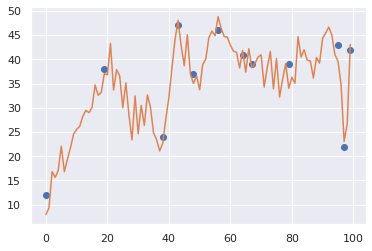

In [181]:
plt.plot(x, y, 'o', x_interpolated, signal, '-')

## Game environment

In [ ]:
class InvestmentGame(gym.Env):
    def __init__(self):
        self.num_rounds = 20
        self.num_initial_chips = 100